In [1]:
import sys
import os
import numpy as np
import pandas as pd
import tweedie
import matplotlib.pyplot as plt
import warnings
import json

from statsmodels.genmod.families.links import Log, Power, Logit, inverse_power
from statsmodels.genmod.families.family import Gamma
from patsy import dmatrix
from scipy.stats import gamma, invgauss, geninvgauss, binom

sys.path.append(os.path.join(sys.path[0], ".."))

from mcglm import MCGLM, mc_id


warnings.filterwarnings("ignore")

betas_logit = {'beta_0': 0.8, 'beta_1': 1, 'beta_2': -1.5}

This notebook conducts some simulations to prove the overall convergence of the library. 

##### Tweedie and Binomial convergence

This section presents a simulation study which validates both Tweedie and Binomial regressions. It produces an outcome vector $Y$ as independent realizations from a model, with the vector $\mu$ as the mean parameters and a constant dispersion parameter $\phi$. To establish a mathematical notation, $Y_i \sim Tw_p(\mu_i, \phi)$ and $g(\mu_i) = \eta_i = x_i\beta$. Moreover, we set three parameters(regression): $\beta_0$, $\beta_1$, and $\beta_2$ defined as (2, 0.8, -1.5) for Tweedie, and (0.8, 1, -1.5) for Binomial, and two covariates: a sequence within -1 to 1 and a categorical two-level randomly chosen with p=0.5. The vector $\mu$ is calculated by means of the linear operation between covariates and regression parameters. Finally, the parameter `power` is vital for Tweedie to emulate the distribution as some EDM - Exponential Dispersion Family; we benchmark four non-standard values for power (1.01, 1.5, 2, and 3). For the Binomial case, we have attempted ten trials. This simulation evaluates the estimates, such as bias, consistency, and coverage rate, on different sample sizes, by thousand attempts.

We leverage four different sample sizes: 100, 250, 500 and 1000; three unique levels of variance for each sample size, generated using coefficient of variation equaling to 15%, 50% and 80%. Therefore, for p=1.01, the dispersion parameters are (1.5, 15, 40); for p=1.5, the dispersion parameters are (0.2, 2, 5.5); for p=2, the dispersion parameters are (0.023, 0.25, 0.65); for p=3, the dispersion parameters are (0.0003, 0.0034, 0.0083). In Binomial case, we will analyze whether the dispersion parameter converges to 1.

We conduct Tweedie simulations for power values 1.01 and 1.5, with the aid of the package {tweedie}. Addition to it, for power values 2 and 3, we leverage the {scipy} library. Finally, for Binomial, {scipy} library runs out simulations. For all simulations, we aim to validate whether the dispersion parameter $\phi$ and regression parameters match. `tweedie` url: https://pypi.org/project/tweedie/, `scipy` url: https://scipy.org/. 

The method below helps us to craft simulation by parameters `n_sim` as number of simulations; `sample_size` as sample size; `dispersion` as the dispersion parameter; `power` as the power parameter. 

Tweedie and Binomial simulation have their own group of parameters for crafting the $\mu$ and the model mcglm configuration. The method "get_link" specifies and implements it thoroughly. 

In [2]:
def parser_estimates(summary_as_csv : str) -> tuple:
    """
    The method parser_estimates parses the textual outcome of mcglm summary. It conveys the confidence intervals for regression parameters, dispersion and the power.  
    """
    list_csv_mcglm = summary_as_csv.replace(" ", "").split(",")[31:]
    
   
    beta_0_cinf = (float(list_csv_mcglm[1]), float(list_csv_mcglm[5]), float(list_csv_mcglm[6].split("\n")[0]))
    beta_2_cinf = (float(list_csv_mcglm[7]), float(list_csv_mcglm[11]), float(list_csv_mcglm[12].split("\n")[0]))
    beta_1_cinf = (float(list_csv_mcglm[13]), float(list_csv_mcglm[17]), float(list_csv_mcglm[18].split("\n")[0]))
               
    dispersion_cinf = (float(list_csv_mcglm[25]), float(list_csv_mcglm[29]), float(list_csv_mcglm[30].split("\n")[0]))
    power_cinf = (float(list_csv_mcglm[37]), float(list_csv_mcglm[41]), float(list_csv_mcglm[42]))
    
    return (beta_0_cinf, beta_2_cinf, beta_1_cinf, dispersion_cinf, power_cinf)


def generate_model_simulation(
    n_sim: int, 
    sample_size: int, 
    dispersion: float, 
    power: float, 
    covariate1 : np.array, 
    covariate2 : np.array, 
    beta_0 : float, 
    beta_1 : float, 
    beta_2 : float,
    model_type : str,
    power_fixed : bool = True
) -> dict:
    """ 
    The method generate_model_simulation runs out simulations for a specific configuration of model and parameters. 
    """ 
    def model_simulation(model_type, mu, dispersion, sample_size, power=None):
        """
        Base method to trigger a random variable realization of sample size as 'sample_size'; expected value as 'mu'; dispersion as 'dispersion' and model type as 'model_type'.
        """
        if model_type == 'tweedie':
            return tweedie.tweedie(mu=mu, p=power, phi=dispersion).rvs(sample_size)
        elif model_type == 'gamma':
            shape = 1 / dispersion
            scale_g = mu * dispersion
            return gamma.rvs(shape, scale=scale_g, size=sample_size) 
        elif model_type == 'invgauss':
            mu_ig = mu * dispersion
            return invgauss.rvs(mu_ig, scale= 1 /dispersion, size=sample_size)
        elif model_type == 'binomial':
            return binom.rvs(n=10, p=mu, size=sample_size)

        
    def get_link(model_type : str):
        if model_type == 'binomial':
            return {'object_link': Logit(), 'link': 'logit', 'variance': 'binomialP'}
        else:
            return {'object_link': Log(), 'link': 'log', 'variance': 'tweedie'}
        
        
    historical_data = {'beta0': [], 'beta1': [], 'beta2': [], 'dispersion': [], 'beta0_confidence_interval': [], 'beta1_confidence_interval': [], 'beta2_confidence_interval':[], 'dispersion_confidence_interval':[], 'power_confidence_interval':[], 'power': []}
    model_conf = get_link(model_type)


    eta = beta_0 + beta_1 * covariate1 + beta_2 * covariate2
    mu = model_conf["object_link"].inverse(eta)
    
    for _ in range(n_sim):
    
        y = model_simulation(model_type=model_type, mu=mu, dispersion=dispersion, sample_size=sample_size, power=power) / 10

        data = pd.DataFrame({"y": y, "cov1": covariate1, "cov2": covariate2})

        data["cov2"] = data["cov2"].astype("str")
        X = dmatrix("~ cov1 + cov2", data, return_type="dataframe")

        # Z specification
        Z = [mc_id(data)]

        # Model fitting
        mcglm = MCGLM(
            endog=data["y"],
            exog=X,
            z=Z,
            link=model_conf["link"],
            variance=model_conf["variance"],
            power=power,
            power_fixed=power_fixed,
            ntrial=10,
        )

        mcglmresults = mcglm.fit()
        
        beta_0_cinf, beta_2_cinf, beta_1_cinf, dispersion_cinf, power_cinf = parser_estimates(mcglmresults.summary().as_csv())
                
        historical_data['beta0'].append(beta_0_cinf[0])
        historical_data['beta1'].append(beta_1_cinf[0])
        historical_data['beta2'].append(beta_2_cinf[0])
        historical_data['dispersion'].append(dispersion_cinf[0])
        historical_data['power'].append(power_cinf[0])
        
        historical_data['beta0_confidence_interval'].append((beta_0_cinf[1] <= beta_0) & (beta_0_cinf[2] >= beta_0))
        historical_data['beta1_confidence_interval'].append((beta_1_cinf[1] <= beta_1) & (beta_1_cinf[2] >= beta_1))
        historical_data['beta2_confidence_interval'].append((beta_2_cinf[1] <= beta_2) & (beta_2_cinf[2] >= beta_2))
        historical_data['dispersion_confidence_interval'].append((dispersion_cinf[1] <= dispersion) & (dispersion_cinf[2] >= dispersion))    
        historical_data['power_confidence_interval'].append((power_cinf[1] <= power) & (power_cinf[2] >= power))    
    
    return historical_data

In [3]:
def histogram_log_simulation(log_simulation, power, sample_size, dispersion, beta_0, beta_1, beta_2, print_power=False):
    
    if print_power:
        figure, axis = plt.subplots(1, 5, figsize=(8,3), constrained_layout=True)
    else:
        figure, axis = plt.subplots(1, 4, figsize=(7,3), constrained_layout=True)

    figure.suptitle("Simulations for Tweedie power = " + str(power) + ", sample_size = " + str(sample_size) + ", dispersion = " + str(dispersion), fontsize=16)
    # Beta 0
    axis[0].hist(log_simulation["beta0"])
    axis[0].set_title("Beta_0 as " + str(beta_0))

    # Beta 1
    axis[1].hist(log_simulation["beta1"])
    axis[1].set_title("Beta_1 as " + str(beta_1))

    # Beta 2
    axis[2].hist(log_simulation["beta2"])
    axis[2].set_title("Beta_2 as " + str(beta_2))
    
    # Dispersion 
    axis[3].hist(log_simulation["dispersion"])
    axis[3].set_title("Dispersion as " + str(dispersion))
    
    if print_power:
        # Power 
        axis[4].hist(log_simulation["power"])
        axis[4].set_title("Power as " + str(power))

    # Plot
    plt.show()
    
def coverage_analysis(log_simulation : dict, dispersion : float, sample_size : int, n_sim : int, power : float):
    return '-- power ' + str(power) + ', dispersion: ' + str(dispersion) + ' sample size: ' + str(sample_size) + '-- \n' + \
    'Coverage Beta_0: ' + str(sum(log_simulation['beta0_confidence_interval'])/n_sim) + '\n' + \
    'Coverage Beta_1: ' + str(sum(log_simulation['beta1_confidence_interval'])/n_sim) + '\n' + \
    'Coverage Beta_2: ' + str(sum(log_simulation['beta2_confidence_interval'])/n_sim) + '\n' + \
    'Coverage Dispersion: ' + str(sum(log_simulation['dispersion_confidence_interval'])/n_sim) + '\n' + \
    'Coverage Power: ' + str(sum(log_simulation['power_confidence_interval'])/n_sim) + '\n' + \
    '----------------------------------------'

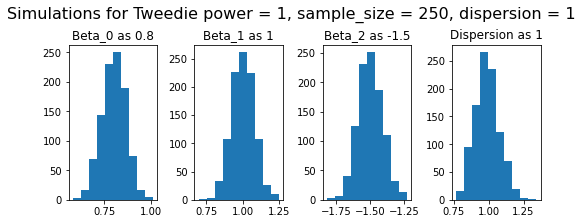

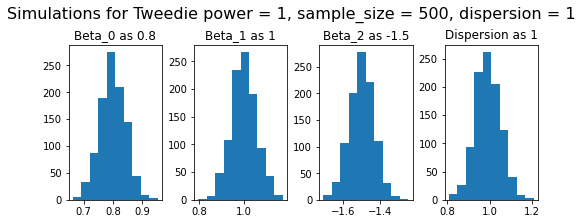

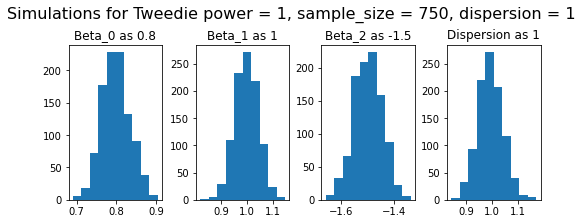

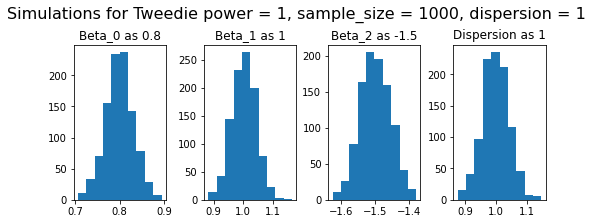

- Simulation report - 
-- power 1, dispersion: 1 sample size: 250-- 
Coverage Beta_0: 0.95
Coverage Beta_1: 0.952
Coverage Beta_2: 0.953
Coverage Dispersion: 0.935
Coverage Power: 0.0
----------------------------------------
-- power 1, dispersion: 1 sample size: 500-- 
Coverage Beta_0: 0.954
Coverage Beta_1: 0.949
Coverage Beta_2: 0.94
Coverage Dispersion: 0.951
Coverage Power: 0.0
----------------------------------------
-- power 1, dispersion: 1 sample size: 750-- 
Coverage Beta_0: 0.955
Coverage Beta_1: 0.958
Coverage Beta_2: 0.951
Coverage Dispersion: 0.949
Coverage Power: 0.0
----------------------------------------
-- power 1, dispersion: 1 sample size: 1000-- 
Coverage Beta_0: 0.95
Coverage Beta_1: 0.942
Coverage Beta_2: 0.958
Coverage Dispersion: 0.947
Coverage Power: 0.0
----------------------------------------


In [31]:
betas_tweedie = {'beta_0': 2, 'beta_1': 0.8, 'beta_2': -1.5}
betas_logit = {'beta_0': 0.8, 'beta_1': 1, 'beta_2': -1.5}

n_sim = 1000

def dump_json(json_name_file : str, log_simulation : dict):
    loc_file = 'log/' + json_name_file + '.json'
    with open(loc_file, 'w') as fh:
        json.dump(log_simulation, fh)

for simulation_conf in [
        #{"power": 1.01, "dispersion":[1.5, 15, 40], "model_type":"tweedie", "regression_parameter": betas_tweedie}, 
        #{"power": 1.5, "dispersion":[0.2, 2, 5.5], "model_type": "tweedie", "regression_parameter": betas_tweedie},
        #{"power": 2, "dispersion":[0.023, 0.25, 0.65], "model_type": "gamma", "regression_parameter": betas_tweedie},
        #{"power": 3, "dispersion":[0.0003, 0.0034, 0.0083], "model_type": "invgauss", "regression_parameter": betas_tweedie},
        {"power": 1, "dispersion":[1], "model_type": "binomial", "regression_parameter": betas_logit}
        ]:
    regression_parameters = simulation_conf["regression_parameter"]
    for dispersion in simulation_conf['dispersion']:
        report = '- Simulation report - '
        for sample_size in [250, 500, 750, 1000]: 
            
            covariate1 = np.arange(
                -1.0, 1.0, 1 / (sample_size / 2)
            )   
            covariate2 = np.random.choice([0, 1], size=sample_size)

            
            simulation = {"n_sim": n_sim, "sample_size": sample_size, "dispersion": dispersion, "power": simulation_conf["power"], "covariate1": covariate1, "covariate2": covariate2, "beta_0":regression_parameters["beta_0"], "beta_1": regression_parameters["beta_1"], "beta_2": regression_parameters["beta_2"], "model_type": simulation_conf["model_type"]}
            
            log_simulation = generate_model_simulation(**simulation)
            
            dump_json('power_'+ str(simulation_conf["power"]) + 
                      '__' + 'n_sim_' + str(n_sim) +  
                      '__' + 'dispersion_' + str(dispersion) + 
                      '__' + 'sample_size_' + str(sample_size), log_simulation)
            
            histogram_log_simulation(log_simulation, 
                                     power=simulation_conf["power"], sample_size=sample_size, dispersion=dispersion, beta_0=regression_parameters["beta_0"], beta_1=regression_parameters["beta_1"],
                                     beta_2=regression_parameters["beta_2"]
                                    )
            report += '\n' + coverage_analysis(log_simulation, dispersion, sample_size, n_sim, simulation_conf["power"])
        print(report)


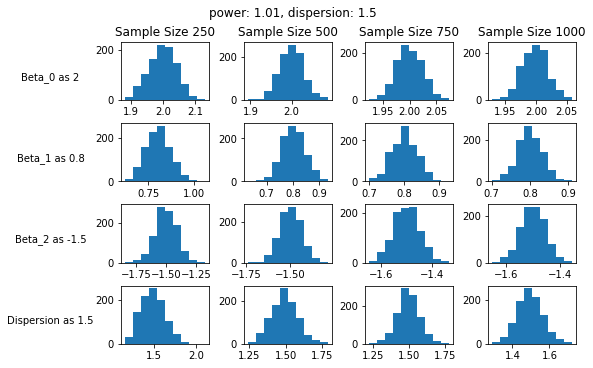

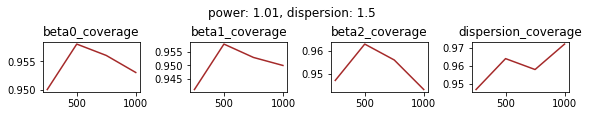

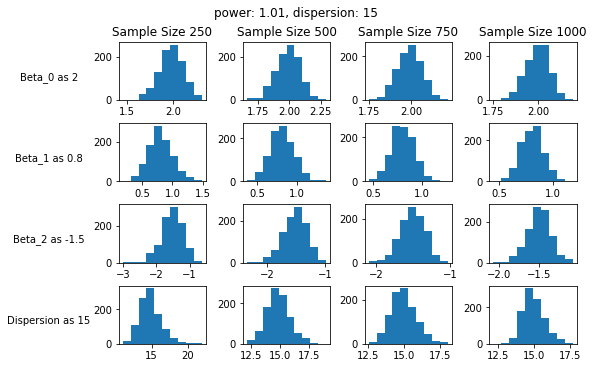

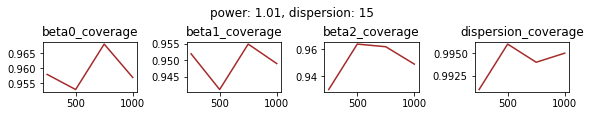

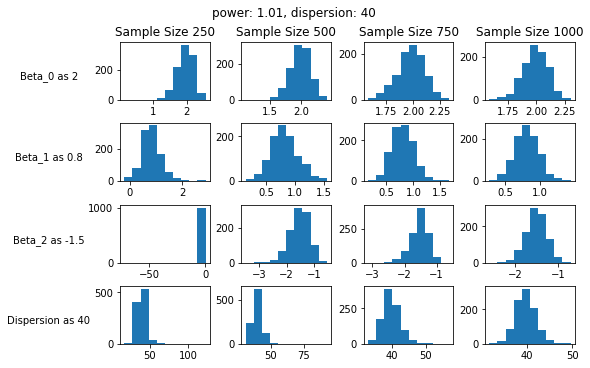

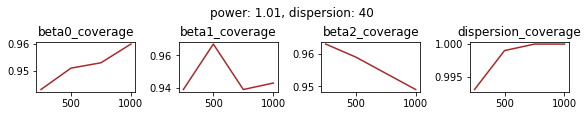

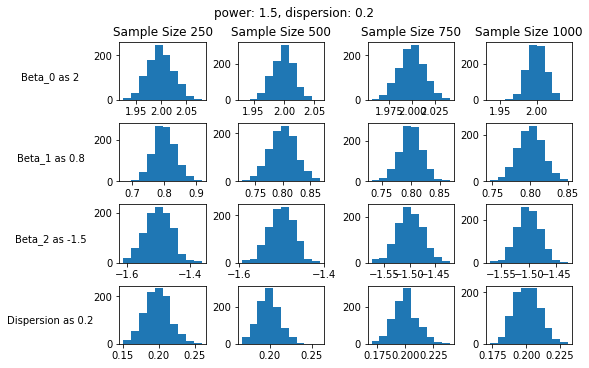

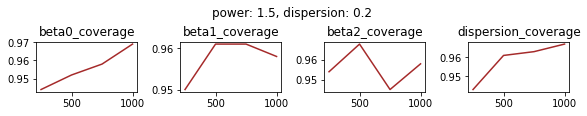

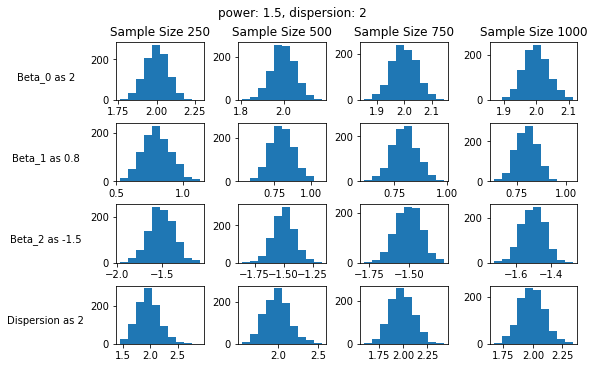

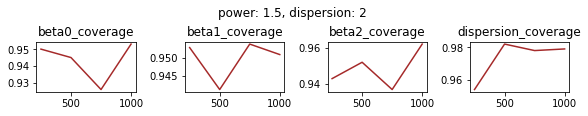

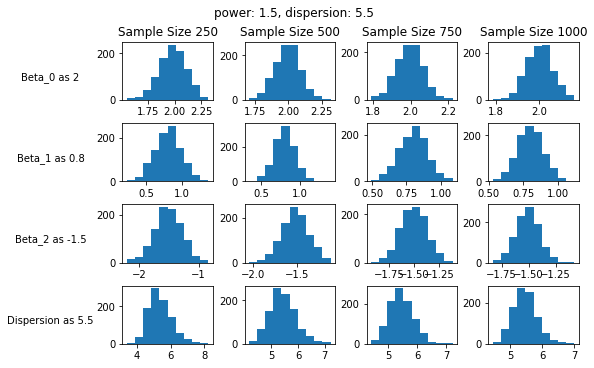

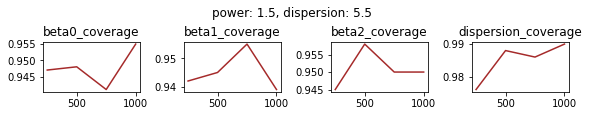

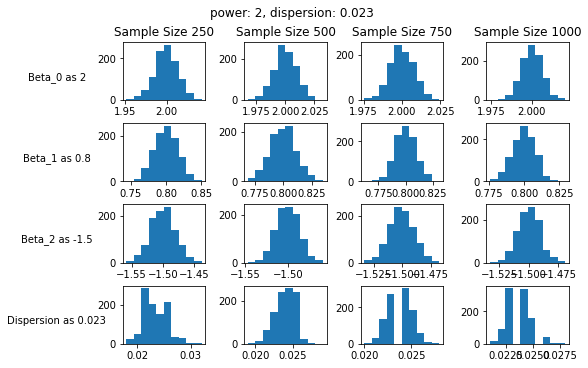

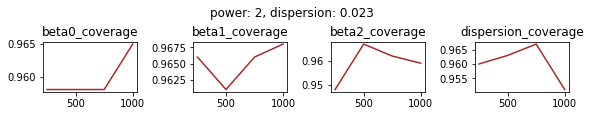

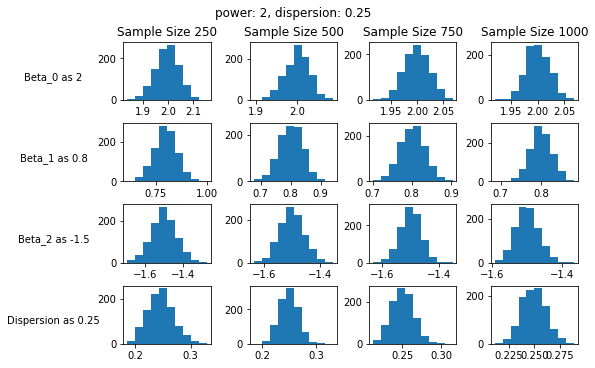

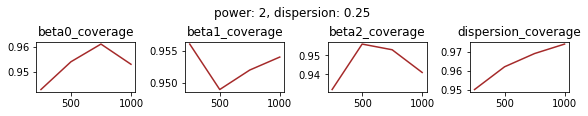

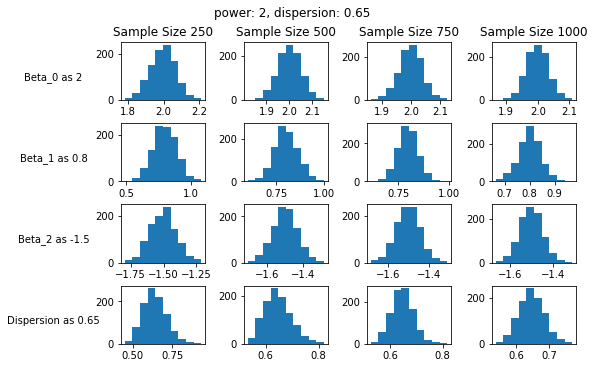

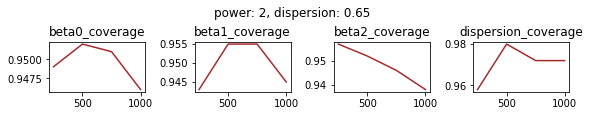

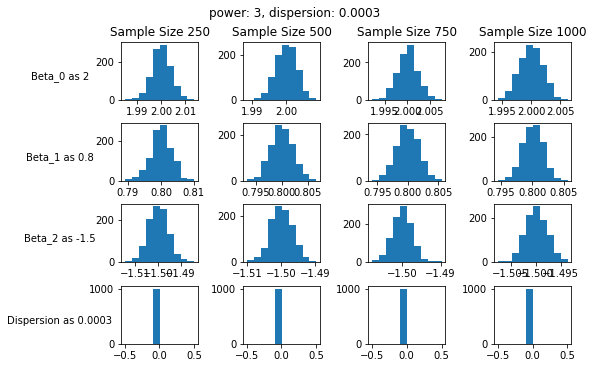

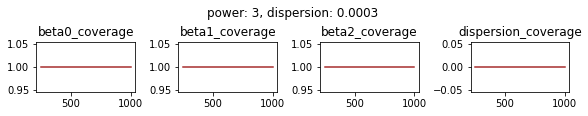

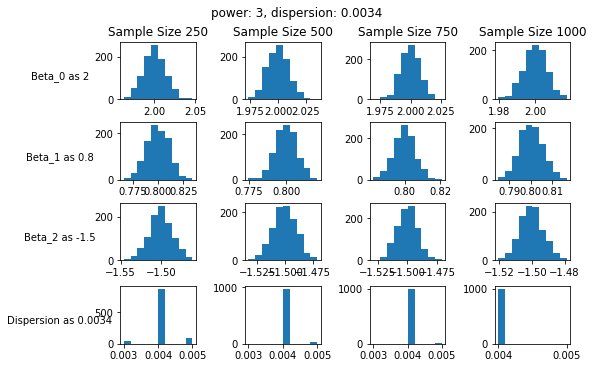

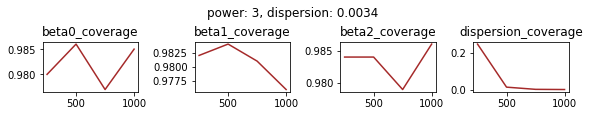

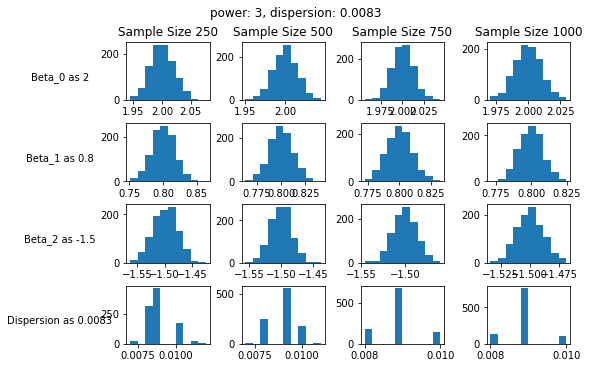

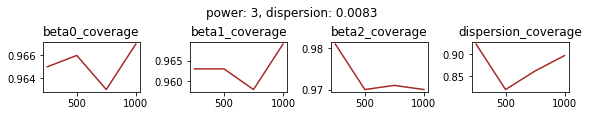

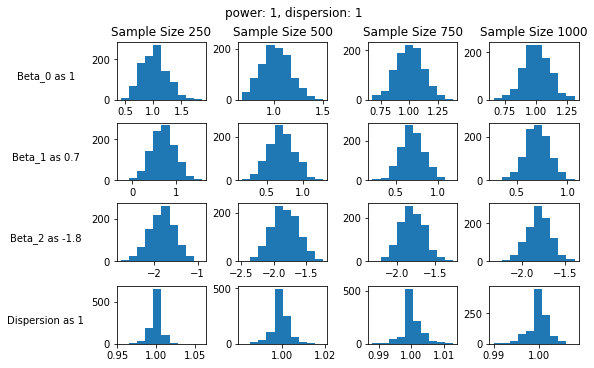

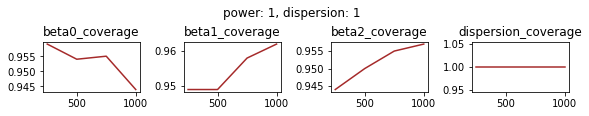

In [40]:

import json

n_sim = 1000
sample_sizes = [250, 500, 750, 1000]
for simulation_conf in [
        #{"power": 1.01, "dispersion":[1.5, 15, 40], "model_type":"tweedie", "regression_parameter": betas_tweedie}, 
        #{"power": 1.5, "dispersion":[0.2, 2, 5.5], "model_type": "tweedie", "regression_parameter": betas_tweedie},
        #{"power": 2, "dispersion":[0.023, 0.25, 0.65], "model_type": "gamma", "regression_parameter": betas_tweedie},
        #{"power": 3, "dispersion":[0.0003, 0.0034, 0.0083], "model_type": "invgauss", "regression_parameter": betas_tweedie},
        {"power": 1, "dispersion":[1], "model_type": "binomial", "regression_parameter": betas_logit}
        ]:
        for dispersion in simulation_conf["dispersion"]:
                
                # print dispersion and power
                beta_0 = list()
                beta_1 = list()
                beta_2 = list()
                dispersion_lst = list()
                
                beta0_coverage = list()
                beta1_coverage = list()
                beta2_coverage = list()
                dispersion_coverage = list()
                for sample_size in range(len(sample_sizes)):     
                        data = json.load(open('log/power_'+ str(simulation_conf["power"]) + \
                                '__' + 'n_sim_' + str(n_sim) +  \
                                '__' + 'dispersion_' + str(dispersion) + \
                                '__' + 'sample_size_' + str(sample_sizes[sample_size])+'.json', 'r'))
                        
                        beta_0.append(data["beta0"])
                        beta_1.append(data["beta1"])
                        beta_2.append(data["beta2"])
                        dispersion_lst.append(data["dispersion"])
                        
                        beta0_coverage.append(sum(data["beta0_confidence_interval"])/n_sim)
                        beta1_coverage.append(sum(data["beta1_confidence_interval"])/n_sim)
                        beta2_coverage.append(sum(data["beta2_confidence_interval"])/n_sim)
                        dispersion_coverage.append(sum(data["dispersion_confidence_interval"])/n_sim)
                        
                        
                figure, axis = plt.subplots(4, 4, figsize=(8,5), constrained_layout=True)
        
                plt.suptitle('power: ' + str(simulation_conf["power"]) +  ', dispersion: ' + str(dispersion))

                for sample_size in range(len(sample_sizes)): 
                        axis[0][sample_size].hist(beta_0[sample_size])
                        axis[0][sample_size].set_title("Sample Size " + str(sample_sizes[sample_size]))     
                axis[0][0].text(-0.8, 0.4, 'Beta_0 as ' + str(simulation_conf['regression_parameter']['beta_0']), horizontalalignment='center', verticalalignment='center', transform=axis[0][0].transAxes)
                
                
                for sample_size in range(len(sample_sizes)): 
                        axis[1][sample_size].hist(beta_1[sample_size])
                axis[1][0].text(-0.8, 0.4, 'Beta_1 as ' + str(simulation_conf['regression_parameter']['beta_1']), horizontalalignment='center', verticalalignment='center', transform=axis[1][0].transAxes)


                for sample_size in range(len(sample_sizes)): 
                        axis[2][sample_size].hist(beta_2[sample_size])
                axis[2][0].text(-0.8, 0.4, 'Beta_2 as ' + str(simulation_conf['regression_parameter']['beta_2']), horizontalalignment='center', verticalalignment='center', transform=axis[2][0].transAxes)

                        
                for sample_size in range(len(sample_sizes)): 
                        axis[3][sample_size].hist(dispersion_lst[sample_size])
                axis[3][0].text(-0.8, 0.4, 'Dispersion as '+str(dispersion), horizontalalignment='center', verticalalignment='center', transform=axis[3][0].transAxes)
                
                
                ### coverage section.
                figure, axis = plt.subplots(1, 4, figsize=(8,1.5), constrained_layout=True)
                plt.suptitle('power: ' + str(simulation_conf["power"]) +  ', dispersion: ' + str(dispersion))

                axis[0].plot(sample_sizes, beta0_coverage, color="brown")
                axis[0].title.set_text('beta0_coverage')           

                axis[1].plot(sample_sizes, beta1_coverage, color="brown")
                axis[1].title.set_text('beta1_coverage')

                axis[2].plot(sample_sizes, beta2_coverage, color="brown")
                axis[2].title.set_text('beta2_coverage')
 
                axis[3].plot(sample_sizes, dispersion_coverage, color="brown")
                axis[3].title.set_text('dispersion_coverage')
                plt.show()
             
                 

New data Viz

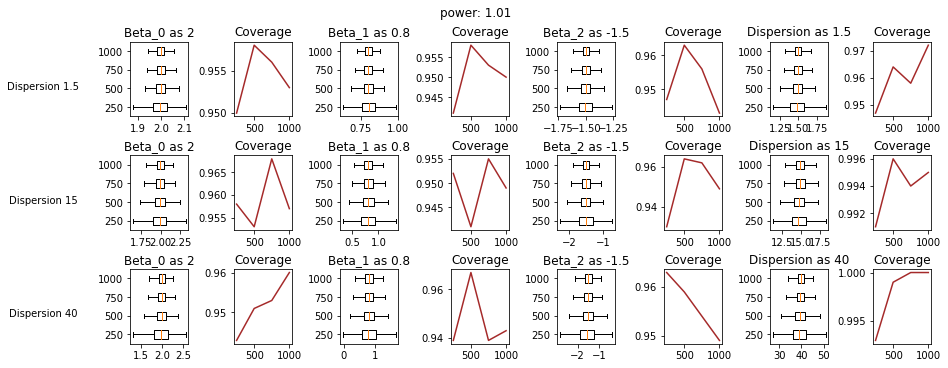

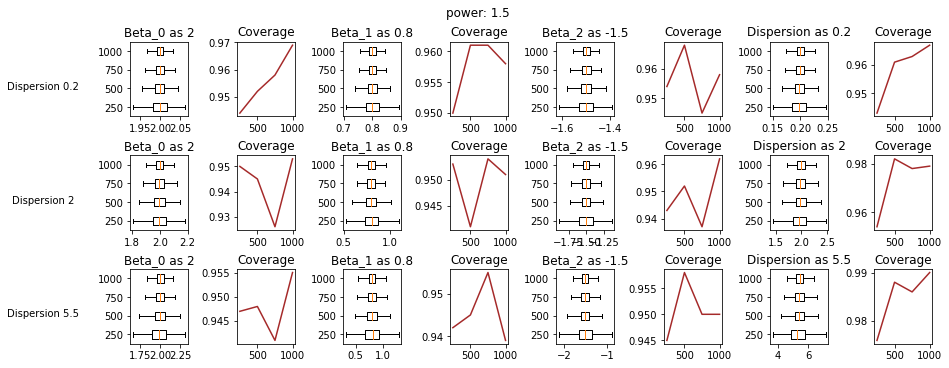

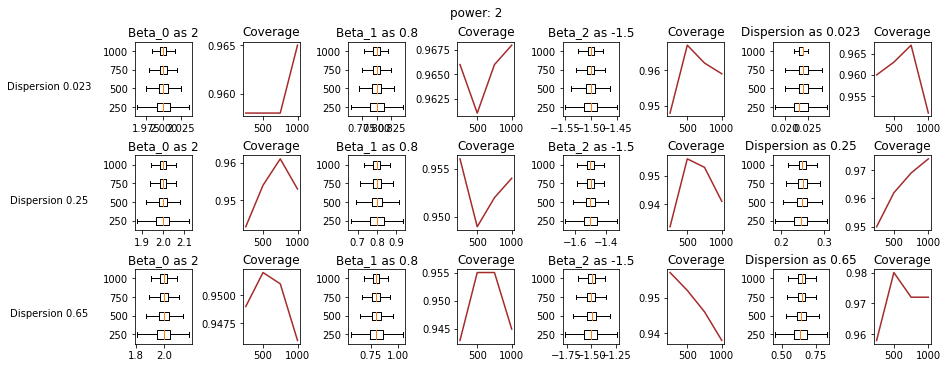

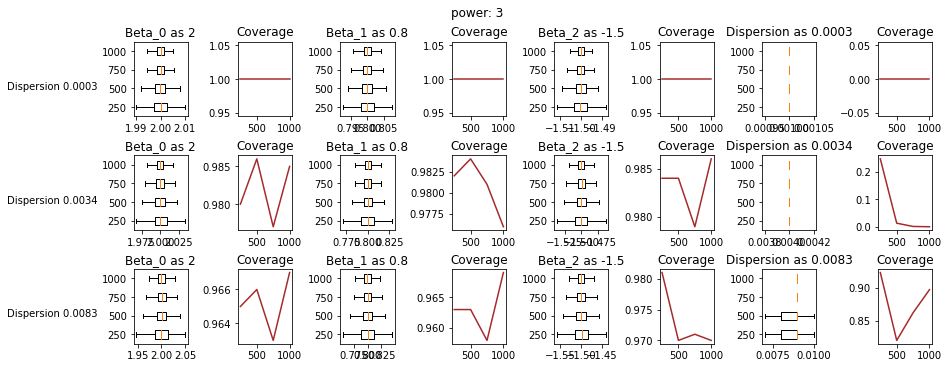

In [36]:

betas_tweedie = {'beta_0': 2, 'beta_1': 0.8, 'beta_2': -1.5}
betas_logit = {'beta_0': 0.8, 'beta_1': 1, 'beta_2': -1.5}

n_sim = 1000
sample_sizes = [250, 500, 750, 1000]
for simulation_conf in [
        {"power": 1.01, "dispersion":[1.5, 15, 40], "model_type":"tweedie", "regression_parameter": betas_tweedie}, 
        {"power": 1.5, "dispersion":[0.2, 2, 5.5], "model_type": "tweedie", "regression_parameter": betas_tweedie},
        {"power": 2, "dispersion":[0.023, 0.25, 0.65], "model_type": "gamma", "regression_parameter": betas_tweedie},
        {"power": 3, "dispersion":[0.0003, 0.0034, 0.0083], "model_type": "invgauss", "regression_parameter": betas_tweedie},
        #{"power": 1, "dispersion":[1], "model_type": "bernoulli", "regression_parameter": betas_logit}
        ]:
        red_square = dict(markerfacecolor='r', marker='s')
        figure, axis = plt.subplots(3, 8, figsize=(13,5), constrained_layout=True)
        plt.suptitle('power: ' + str(simulation_conf["power"]))
        
        for index_dispersion in range(len(simulation_conf["dispersion"])):
                dispersion = simulation_conf["dispersion"][index_dispersion]
                # print dispersion and power
                beta_0 = list()
                beta_1 = list()
                beta_2 = list()
                dispersion_lst = list()
                
                beta0_coverage = list()
                beta1_coverage = list()
                beta2_coverage = list()
                dispersion_coverage = list()
                for sample_size in sample_sizes:     
                        data = json.load(open('log/power_'+ str(simulation_conf["power"]) + \
                                '__' + 'n_sim_' + str(n_sim) +  \
                                '__' + 'dispersion_' + str(dispersion) + \
                                '__' + 'sample_size_' + str(sample_size)+'.json', 'r'))
                        
                        beta_0.append(data["beta0"])
                        beta_1.append(data["beta1"])
                        beta_2.append(data["beta2"])
                        dispersion_lst.append(data["dispersion"])
                        
                        beta0_coverage.append(sum(data["beta0_confidence_interval"])/n_sim)
                        beta1_coverage.append(sum(data["beta1_confidence_interval"])/n_sim)
                        beta2_coverage.append(sum(data["beta2_confidence_interval"])/n_sim)
                        dispersion_coverage.append(sum(data["dispersion_confidence_interval"])/n_sim)
   
                axis[index_dispersion][0].boxplot(beta_0, vert=False, labels=sample_sizes, showfliers=False)
                axis[index_dispersion][0].set_title("Beta_0 as " + str(simulation_conf['regression_parameter']['beta_0']))
                axis[index_dispersion][1].plot(sample_sizes, beta0_coverage, color="brown")
                axis[index_dispersion][1].set_title("Coverage")
                #for sample_size in range(len(sample_sizes)): 
                #        axis[1][sample_size].hist(beta_1[sample_size])
                
                axis[index_dispersion][2].boxplot(beta_1, vert=False, labels=sample_sizes, showfliers=False)
                axis[index_dispersion][2].set_title("Beta_1 as " + str(simulation_conf['regression_parameter']['beta_1']))
                axis[index_dispersion][3].plot(sample_sizes, beta1_coverage, color="brown")
                axis[index_dispersion][3].set_title("Coverage")

                #for sample_size in range(len(sample_sizes)): 
                #        axis[2][sample_size].hist(beta_2[sample_size])
                axis[index_dispersion][4].boxplot(beta_2, vert=False, labels=sample_sizes, showfliers=False)
                axis[index_dispersion][4].set_title("Beta_2 as " + str(simulation_conf['regression_parameter']['beta_2']))   
                axis[index_dispersion][5].plot(sample_sizes, beta2_coverage, color="brown")
                axis[index_dispersion][5].set_title("Coverage")
                

                axis[index_dispersion][6].boxplot(dispersion_lst, vert=False, labels=sample_sizes, showfliers=False)
                axis[index_dispersion][6].set_title("Dispersion as "+str(dispersion))
                axis[index_dispersion][7].plot(sample_sizes, dispersion_coverage, color="brown")
                axis[index_dispersion][7].set_title("Coverage")

        axis[0][0].text(-1.5, 0.4, 'Dispersion '+str(simulation_conf["dispersion"][0]), horizontalalignment='center', verticalalignment='center', transform=axis[0][0].transAxes)
                
        axis[1][0].text(-1.5, 0.4, 'Dispersion '+str(simulation_conf["dispersion"][1]), horizontalalignment='center', verticalalignment='center', transform=axis[1][0].transAxes)
        
        axis[2][0].text(-1.5, 0.4, 'Dispersion '+str(simulation_conf["dispersion"][2]), horizontalalignment='center', verticalalignment='center', transform=axis[2][0].transAxes)
        plt.show()
             
                 

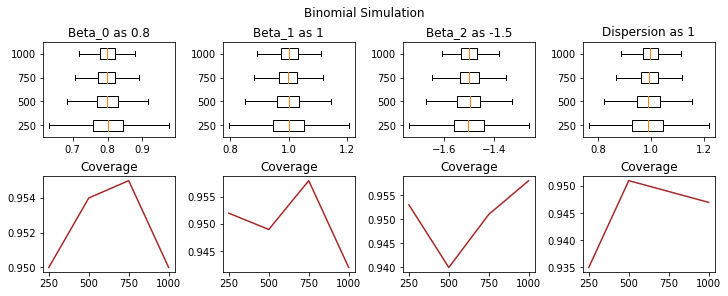

In [6]:
betas_logit = {'beta_0': 0.8, 'beta_1': 1, 'beta_2': -1.5}

n_sim = 1000
sample_sizes = [250, 500, 750, 1000]
for simulation_conf in [
        {"power": 1, "dispersion":[1], "model_type": "binomial", "regression_parameter": betas_logit}
        ]:
        red_square = dict(markerfacecolor='r', marker='s')
        figure, axis = plt.subplots(2, 4, figsize=(10,4), constrained_layout=True)
        plt.suptitle("Binomial Simulation")
        
        for index_dispersion in range(len(simulation_conf["dispersion"])):
                dispersion = simulation_conf["dispersion"][index_dispersion]

                beta_0 = list()
                beta_1 = list()
                beta_2 = list()
                dispersion_lst = list()
                
                beta0_coverage = list()
                beta1_coverage = list()
                beta2_coverage = list()
                dispersion_coverage = list()
                for sample_size in range(len(sample_sizes)):     
                        data = json.load(open('log/power_'+ str(simulation_conf["power"]) + \
                                '__' + 'n_sim_' + str(n_sim) +  \
                                '__' + 'dispersion_' + str(dispersion) + \
                                '__' + 'sample_size_' + str(sample_sizes[sample_size])+'.json', 'r'))
                        
                        beta_0.append(data["beta0"])
                        beta_1.append(data["beta1"])
                        beta_2.append(data["beta2"])
                        dispersion_lst.append(data["dispersion"])
                        
                        beta0_coverage.append(sum(data["beta0_confidence_interval"])/n_sim)
                        beta1_coverage.append(sum(data["beta1_confidence_interval"])/n_sim)
                        beta2_coverage.append(sum(data["beta2_confidence_interval"])/n_sim)
                        dispersion_coverage.append(sum(data["dispersion_confidence_interval"])/n_sim)
                        
                        
               

                axis[0][0].boxplot(beta_0, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][0].set_title("Beta_0 as " + str(simulation_conf['regression_parameter']['beta_0']))
                axis[1][0].plot(sample_sizes, beta0_coverage, color="brown")
                axis[1][0].set_title("Coverage")

                axis[0][1].boxplot(beta_1, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][1].set_title("Beta_1 as " + str(simulation_conf['regression_parameter']['beta_1']))
                axis[1][1].plot(sample_sizes, beta1_coverage, color="brown")
                axis[1][1].set_title("Coverage")

                axis[0][2].boxplot(beta_2, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][2].set_title("Beta_2 as " + str(simulation_conf['regression_parameter']['beta_2']))   
                axis[1][2].plot(sample_sizes, beta2_coverage, color="brown")
                axis[1][2].set_title("Coverage")
                
                axis[0][3].boxplot(dispersion_lst, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][3].set_title("Dispersion as "+str(dispersion))
                axis[1][3].plot(sample_sizes, dispersion_coverage, color="brown")
                axis[1][3].set_title("Coverage")

        plt.show()

                 

#### Tweedie convergence with optimal power.

The library `mcglm` can also adjust for the optimal `power`. In this section, we expand the last one and define the model to estimate the `power` too. 


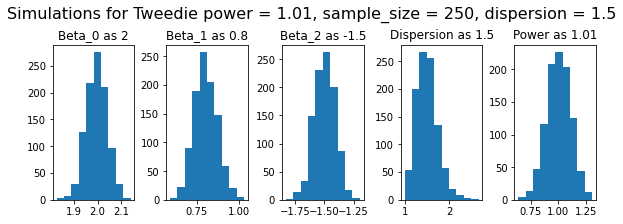

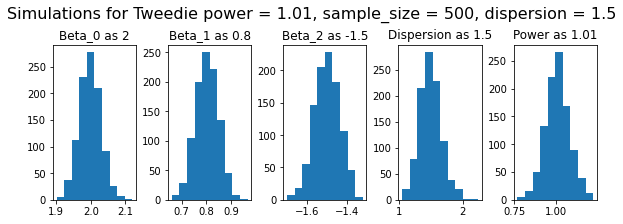

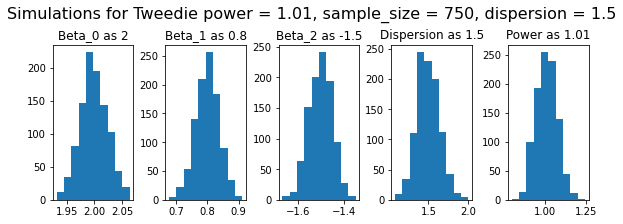

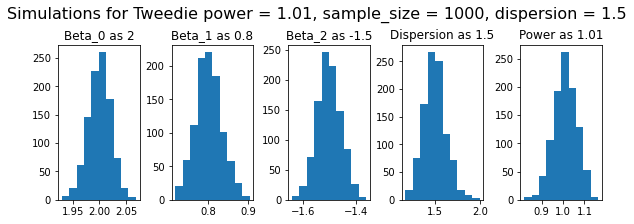

- Simulation report - 
-- power 1.01, dispersion: 1.5 sample size: 250-- 
Coverage Beta_0: 0.95
Coverage Beta_1: 0.945
Coverage Beta_2: 0.944
Coverage Dispersion: 0.924
Coverage Power: 0.934
----------------------------------------
-- power 1.01, dispersion: 1.5 sample size: 500-- 
Coverage Beta_0: 0.943
Coverage Beta_1: 0.956
Coverage Beta_2: 0.961
Coverage Dispersion: 0.942
Coverage Power: 0.937
----------------------------------------
-- power 1.01, dispersion: 1.5 sample size: 750-- 
Coverage Beta_0: 0.952
Coverage Beta_1: 0.942
Coverage Beta_2: 0.955
Coverage Dispersion: 0.954
Coverage Power: 0.953
----------------------------------------
-- power 1.01, dispersion: 1.5 sample size: 1000-- 
Coverage Beta_0: 0.951
Coverage Beta_1: 0.953
Coverage Beta_2: 0.946
Coverage Dispersion: 0.959
Coverage Power: 0.959
----------------------------------------


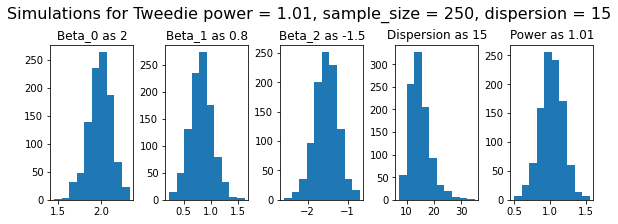

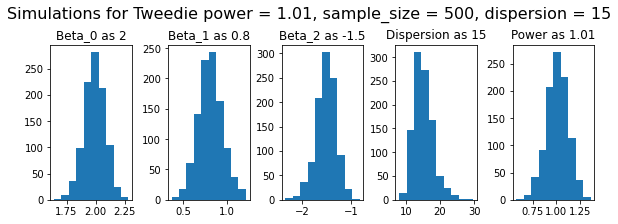

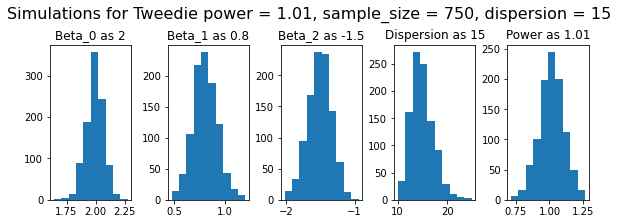

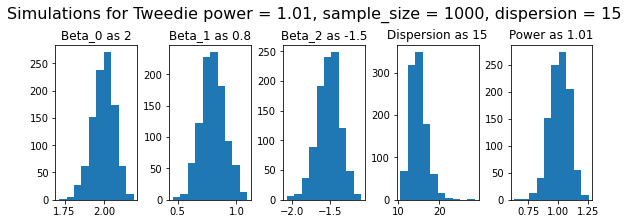

- Simulation report - 
-- power 1.01, dispersion: 15 sample size: 250-- 
Coverage Beta_0: 0.942
Coverage Beta_1: 0.943
Coverage Beta_2: 0.961
Coverage Dispersion: 0.974
Coverage Power: 0.955
----------------------------------------
-- power 1.01, dispersion: 15 sample size: 500-- 
Coverage Beta_0: 0.955
Coverage Beta_1: 0.955
Coverage Beta_2: 0.95
Coverage Dispersion: 0.983
Coverage Power: 0.982
----------------------------------------
-- power 1.01, dispersion: 15 sample size: 750-- 
Coverage Beta_0: 0.957
Coverage Beta_1: 0.945
Coverage Beta_2: 0.953
Coverage Dispersion: 0.99
Coverage Power: 0.981
----------------------------------------
-- power 1.01, dispersion: 15 sample size: 1000-- 
Coverage Beta_0: 0.932
Coverage Beta_1: 0.948
Coverage Beta_2: 0.948
Coverage Dispersion: 0.992
Coverage Power: 0.989
----------------------------------------


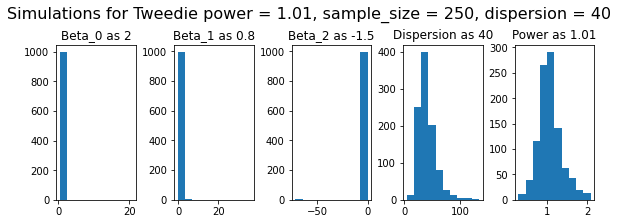

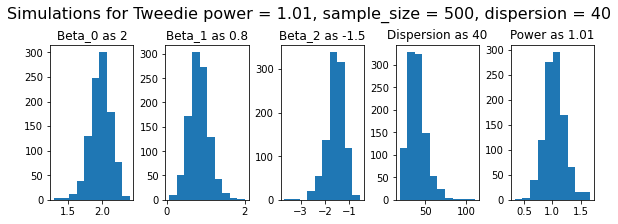

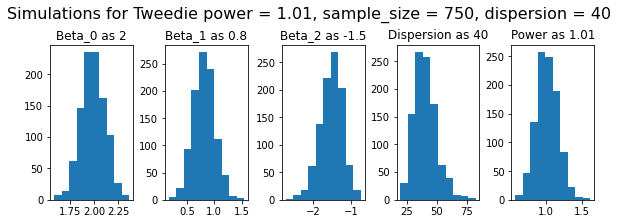

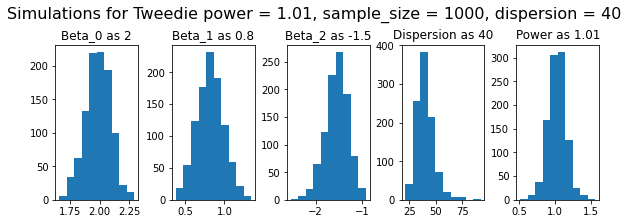

- Simulation report - 
-- power 1.01, dispersion: 40 sample size: 250-- 
Coverage Beta_0: 0.949
Coverage Beta_1: 0.908
Coverage Beta_2: 0.926
Coverage Dispersion: 0.942
Coverage Power: 0.85
----------------------------------------
-- power 1.01, dispersion: 40 sample size: 500-- 
Coverage Beta_0: 0.952
Coverage Beta_1: 0.935
Coverage Beta_2: 0.944
Coverage Dispersion: 0.958
Coverage Power: 0.933
----------------------------------------
-- power 1.01, dispersion: 40 sample size: 750-- 
Coverage Beta_0: 0.957
Coverage Beta_1: 0.941
Coverage Beta_2: 0.943
Coverage Dispersion: 0.97
Coverage Power: 0.955
----------------------------------------
-- power 1.01, dispersion: 40 sample size: 1000-- 
Coverage Beta_0: 0.954
Coverage Beta_1: 0.952
Coverage Beta_2: 0.951
Coverage Dispersion: 0.984
Coverage Power: 0.972
----------------------------------------


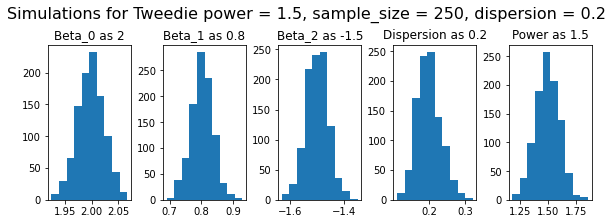

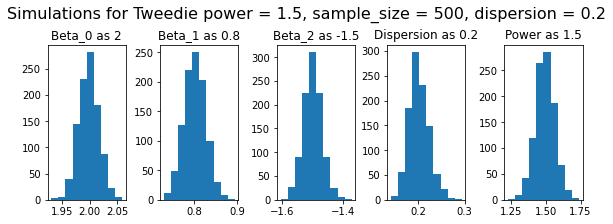

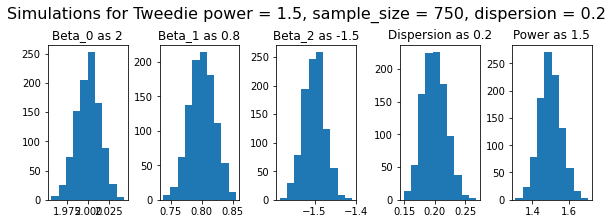

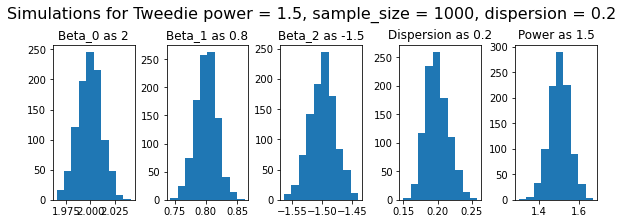

- Simulation report - 
-- power 1.5, dispersion: 0.2 sample size: 250-- 
Coverage Beta_0: 0.945
Coverage Beta_1: 0.951
Coverage Beta_2: 0.949
Coverage Dispersion: 0.937
Coverage Power: 0.928
----------------------------------------
-- power 1.5, dispersion: 0.2 sample size: 500-- 
Coverage Beta_0: 0.953
Coverage Beta_1: 0.95
Coverage Beta_2: 0.943
Coverage Dispersion: 0.964
Coverage Power: 0.953
----------------------------------------
-- power 1.5, dispersion: 0.2 sample size: 750-- 
Coverage Beta_0: 0.957
Coverage Beta_1: 0.954
Coverage Beta_2: 0.938
Coverage Dispersion: 0.947
Coverage Power: 0.955
----------------------------------------
-- power 1.5, dispersion: 0.2 sample size: 1000-- 
Coverage Beta_0: 0.961
Coverage Beta_1: 0.953
Coverage Beta_2: 0.943
Coverage Dispersion: 0.96
Coverage Power: 0.953
----------------------------------------


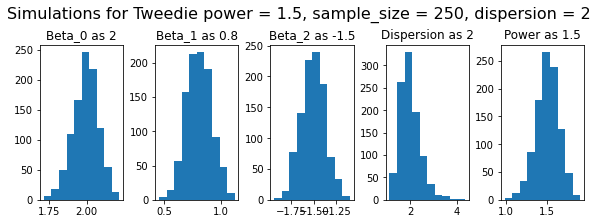

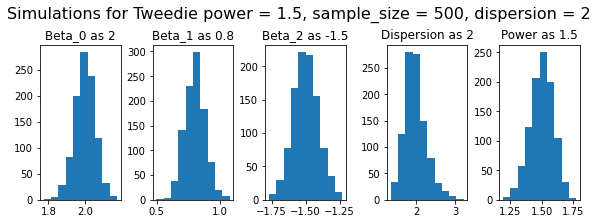

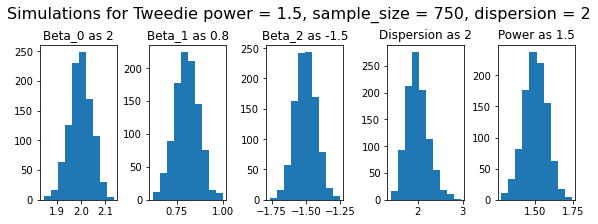

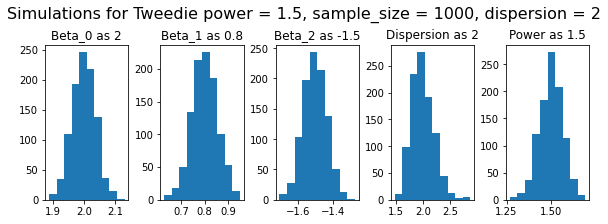

- Simulation report - 
-- power 1.5, dispersion: 2 sample size: 250-- 
Coverage Beta_0: 0.925
Coverage Beta_1: 0.955
Coverage Beta_2: 0.955
Coverage Dispersion: 0.934
Coverage Power: 0.944
----------------------------------------
-- power 1.5, dispersion: 2 sample size: 500-- 
Coverage Beta_0: 0.934
Coverage Beta_1: 0.95
Coverage Beta_2: 0.951
Coverage Dispersion: 0.959
Coverage Power: 0.973
----------------------------------------
-- power 1.5, dispersion: 2 sample size: 750-- 
Coverage Beta_0: 0.956
Coverage Beta_1: 0.956
Coverage Beta_2: 0.948
Coverage Dispersion: 0.966
Coverage Power: 0.979
----------------------------------------
-- power 1.5, dispersion: 2 sample size: 1000-- 
Coverage Beta_0: 0.955
Coverage Beta_1: 0.949
Coverage Beta_2: 0.952
Coverage Dispersion: 0.985
Coverage Power: 0.981
----------------------------------------


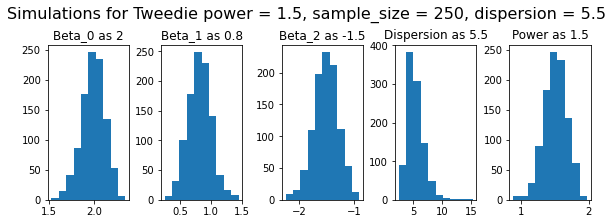

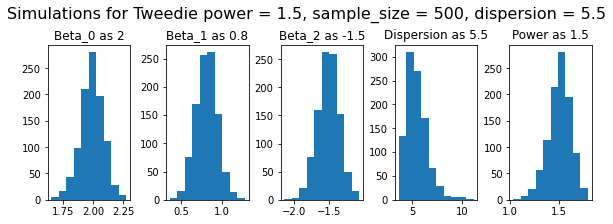

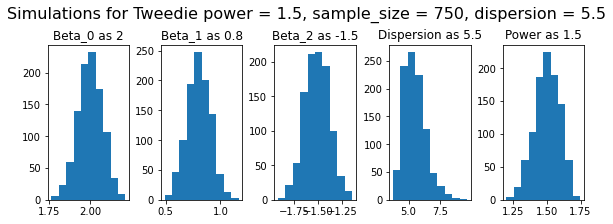

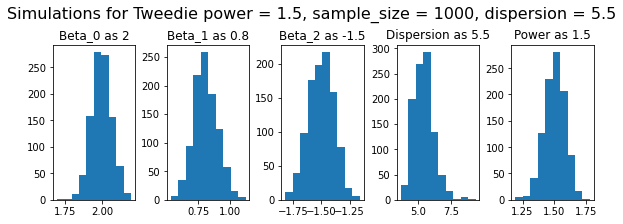

- Simulation report - 
-- power 1.5, dispersion: 5.5 sample size: 250-- 
Coverage Beta_0: 0.945
Coverage Beta_1: 0.941
Coverage Beta_2: 0.942
Coverage Dispersion: 0.929
Coverage Power: 0.953
----------------------------------------
-- power 1.5, dispersion: 5.5 sample size: 500-- 
Coverage Beta_0: 0.946
Coverage Beta_1: 0.94
Coverage Beta_2: 0.951
Coverage Dispersion: 0.973
Coverage Power: 0.979
----------------------------------------
-- power 1.5, dispersion: 5.5 sample size: 750-- 
Coverage Beta_0: 0.943
Coverage Beta_1: 0.954
Coverage Beta_2: 0.953
Coverage Dispersion: 0.982
Coverage Power: 0.99
----------------------------------------
-- power 1.5, dispersion: 5.5 sample size: 1000-- 
Coverage Beta_0: 0.944
Coverage Beta_1: 0.947
Coverage Beta_2: 0.952
Coverage Dispersion: 0.973
Coverage Power: 0.989
----------------------------------------


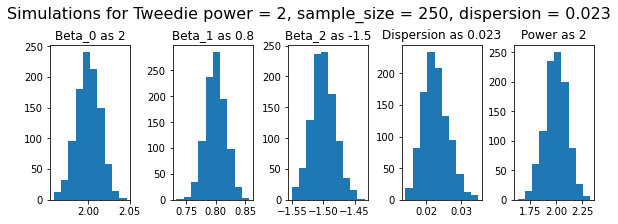

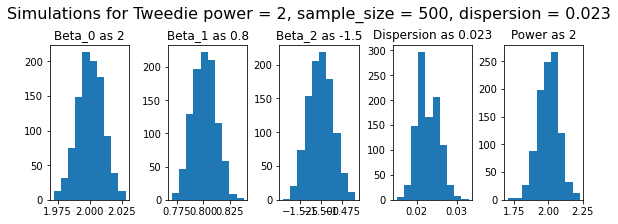

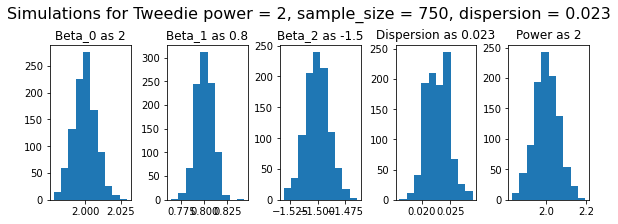

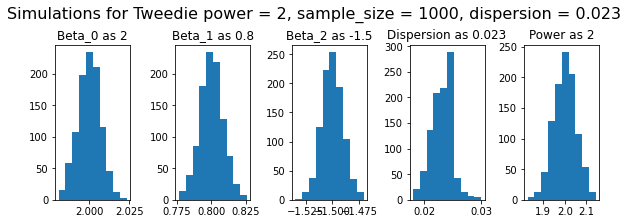

- Simulation report - 
-- power 2, dispersion: 0.023 sample size: 250-- 
Coverage Beta_0: 0.951
Coverage Beta_1: 0.946
Coverage Beta_2: 0.948
Coverage Dispersion: 0.947
Coverage Power: 0.921
----------------------------------------
-- power 2, dispersion: 0.023 sample size: 500-- 
Coverage Beta_0: 0.946
Coverage Beta_1: 0.965
Coverage Beta_2: 0.952
Coverage Dispersion: 0.954
Coverage Power: 0.938
----------------------------------------
-- power 2, dispersion: 0.023 sample size: 750-- 
Coverage Beta_0: 0.954
Coverage Beta_1: 0.964
Coverage Beta_2: 0.952
Coverage Dispersion: 0.953
Coverage Power: 0.939
----------------------------------------
-- power 2, dispersion: 0.023 sample size: 1000-- 
Coverage Beta_0: 0.959
Coverage Beta_1: 0.951
Coverage Beta_2: 0.95
Coverage Dispersion: 0.969
Coverage Power: 0.948
----------------------------------------


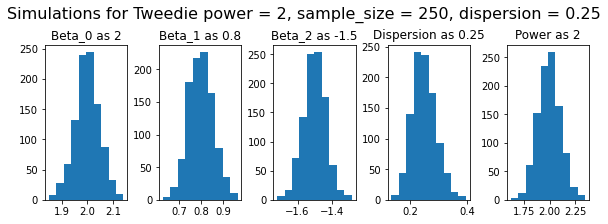

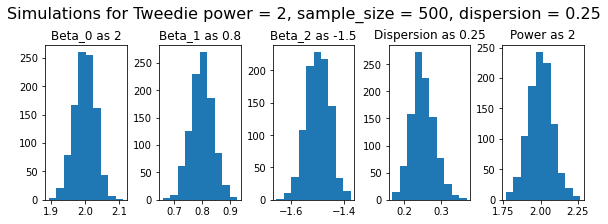

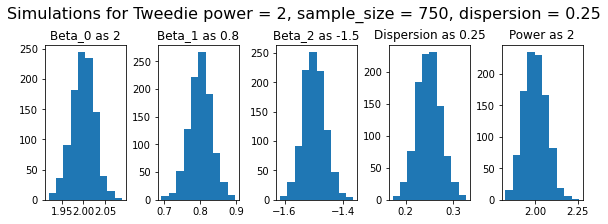

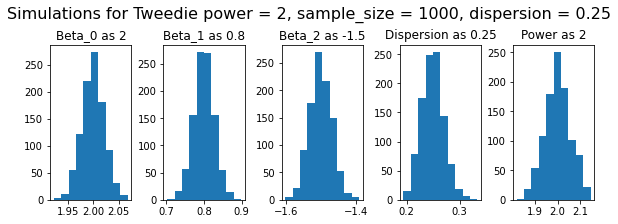

- Simulation report - 
-- power 2, dispersion: 0.25 sample size: 250-- 
Coverage Beta_0: 0.927
Coverage Beta_1: 0.939
Coverage Beta_2: 0.948
Coverage Dispersion: 0.928
Coverage Power: 0.95
----------------------------------------
-- power 2, dispersion: 0.25 sample size: 500-- 
Coverage Beta_0: 0.957
Coverage Beta_1: 0.945
Coverage Beta_2: 0.959
Coverage Dispersion: 0.949
Coverage Power: 0.964
----------------------------------------
-- power 2, dispersion: 0.25 sample size: 750-- 
Coverage Beta_0: 0.949
Coverage Beta_1: 0.942
Coverage Beta_2: 0.949
Coverage Dispersion: 0.96
Coverage Power: 0.974
----------------------------------------
-- power 2, dispersion: 0.25 sample size: 1000-- 
Coverage Beta_0: 0.951
Coverage Beta_1: 0.948
Coverage Beta_2: 0.958
Coverage Dispersion: 0.965
Coverage Power: 0.974
----------------------------------------


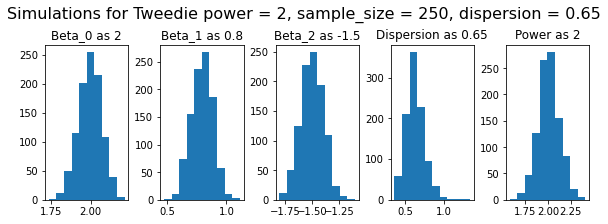

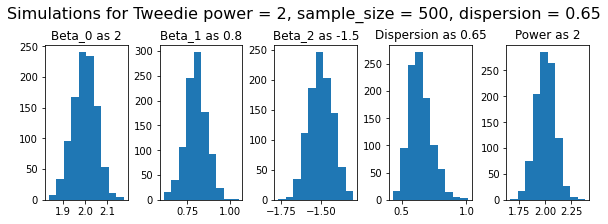

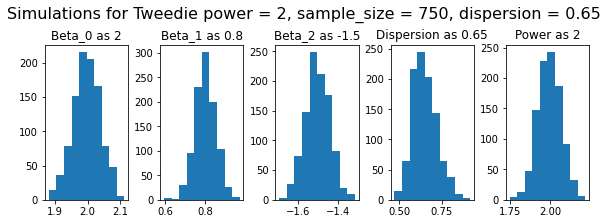

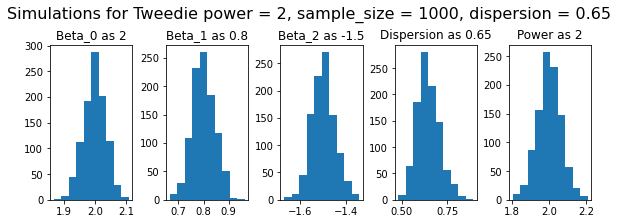

- Simulation report - 
-- power 2, dispersion: 0.65 sample size: 250-- 
Coverage Beta_0: 0.944
Coverage Beta_1: 0.951
Coverage Beta_2: 0.94
Coverage Dispersion: 0.915
Coverage Power: 0.97
----------------------------------------
-- power 2, dispersion: 0.65 sample size: 500-- 
Coverage Beta_0: 0.945
Coverage Beta_1: 0.946
Coverage Beta_2: 0.947
Coverage Dispersion: 0.962
Coverage Power: 0.986
----------------------------------------
-- power 2, dispersion: 0.65 sample size: 750-- 
Coverage Beta_0: 0.961
Coverage Beta_1: 0.947
Coverage Beta_2: 0.941
Coverage Dispersion: 0.979
Coverage Power: 0.983
----------------------------------------
-- power 2, dispersion: 0.65 sample size: 1000-- 
Coverage Beta_0: 0.96
Coverage Beta_1: 0.951
Coverage Beta_2: 0.949
Coverage Dispersion: 0.978
Coverage Power: 0.982
----------------------------------------


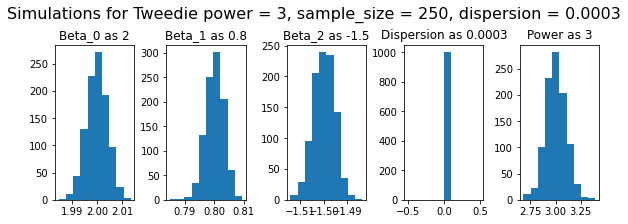

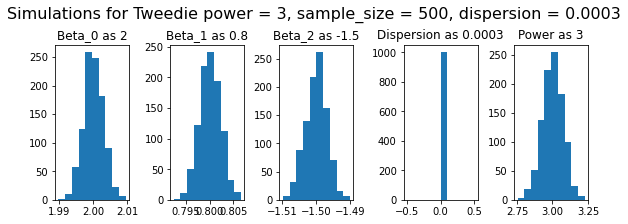

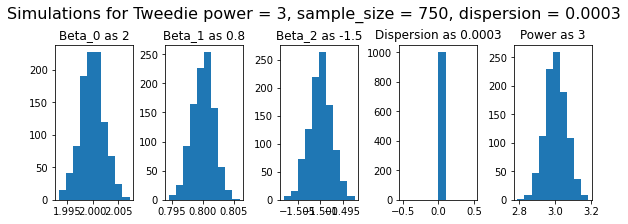

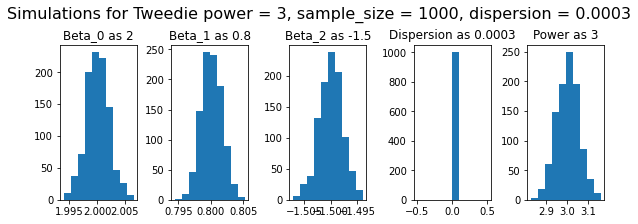

- Simulation report - 
-- power 3, dispersion: 0.0003 sample size: 250-- 
Coverage Beta_0: 0.964
Coverage Beta_1: 0.966
Coverage Beta_2: 0.963
Coverage Dispersion: 0.0
Coverage Power: 0.936
----------------------------------------
-- power 3, dispersion: 0.0003 sample size: 500-- 
Coverage Beta_0: 0.962
Coverage Beta_1: 0.975
Coverage Beta_2: 0.961
Coverage Dispersion: 0.0
Coverage Power: 0.944
----------------------------------------
-- power 3, dispersion: 0.0003 sample size: 750-- 
Coverage Beta_0: 0.965
Coverage Beta_1: 0.973
Coverage Beta_2: 0.968
Coverage Dispersion: 0.0
Coverage Power: 0.931
----------------------------------------
-- power 3, dispersion: 0.0003 sample size: 1000-- 
Coverage Beta_0: 0.965
Coverage Beta_1: 0.981
Coverage Beta_2: 0.961
Coverage Dispersion: 0.0
Coverage Power: 0.934
----------------------------------------


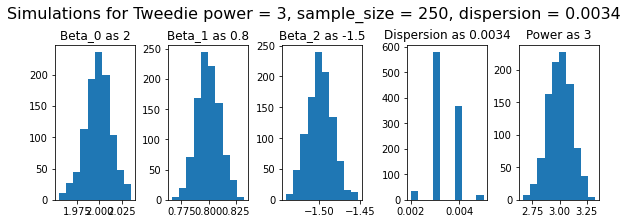

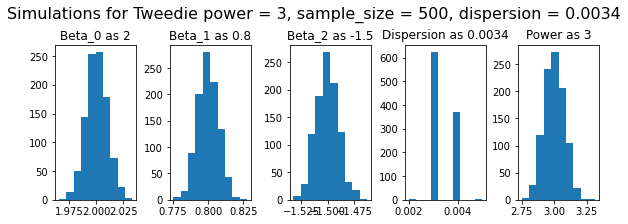

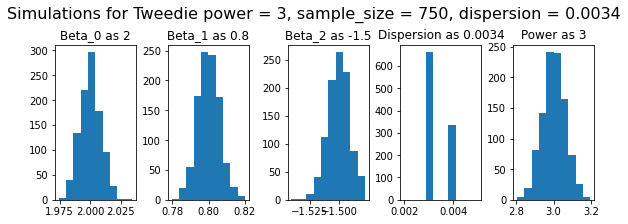

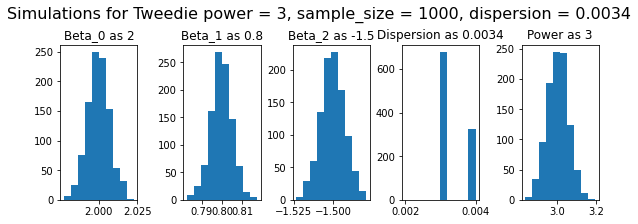

- Simulation report - 
-- power 3, dispersion: 0.0034 sample size: 250-- 
Coverage Beta_0: 0.937
Coverage Beta_1: 0.954
Coverage Beta_2: 0.954
Coverage Dispersion: 0.956
Coverage Power: 0.925
----------------------------------------
-- power 3, dispersion: 0.0034 sample size: 500-- 
Coverage Beta_0: 0.958
Coverage Beta_1: 0.961
Coverage Beta_2: 0.953
Coverage Dispersion: 0.992
Coverage Power: 0.943
----------------------------------------
-- power 3, dispersion: 0.0034 sample size: 750-- 
Coverage Beta_0: 0.944
Coverage Beta_1: 0.959
Coverage Beta_2: 0.943
Coverage Dispersion: 0.91
Coverage Power: 0.951
----------------------------------------
-- power 3, dispersion: 0.0034 sample size: 1000-- 
Coverage Beta_0: 0.946
Coverage Beta_1: 0.95
Coverage Beta_2: 0.949
Coverage Dispersion: 0.589
Coverage Power: 0.951
----------------------------------------


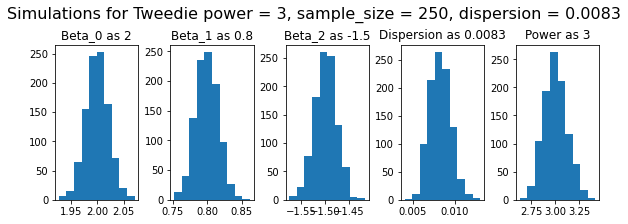

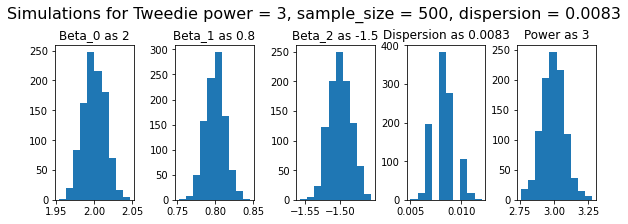

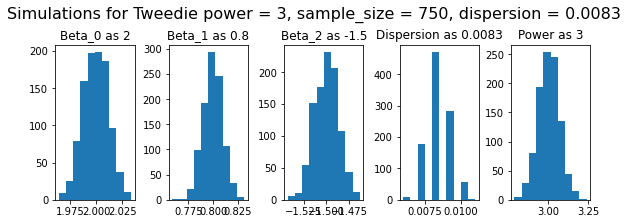

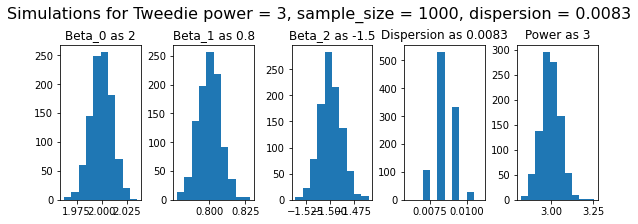

- Simulation report - 
-- power 3, dispersion: 0.0083 sample size: 250-- 
Coverage Beta_0: 0.947
Coverage Beta_1: 0.957
Coverage Beta_2: 0.95
Coverage Dispersion: 0.889
Coverage Power: 0.911
----------------------------------------
-- power 3, dispersion: 0.0083 sample size: 500-- 
Coverage Beta_0: 0.966
Coverage Beta_1: 0.94
Coverage Beta_2: 0.971
Coverage Dispersion: 0.901
Coverage Power: 0.931
----------------------------------------
-- power 3, dispersion: 0.0083 sample size: 750-- 
Coverage Beta_0: 0.956
Coverage Beta_1: 0.959
Coverage Beta_2: 0.959
Coverage Dispersion: 0.837
Coverage Power: 0.948
----------------------------------------
-- power 3, dispersion: 0.0083 sample size: 1000-- 
Coverage Beta_0: 0.953
Coverage Beta_1: 0.958
Coverage Beta_2: 0.954
Coverage Dispersion: 0.879
Coverage Power: 0.952
----------------------------------------


In [27]:
betas_tweedie = {'beta_0': 2, 'beta_1': 0.8, 'beta_2': -1.5}

n_sim = 1000

def dump_json(json_name_file : str, log_simulation : dict):
    loc_file = 'log/fixed_power/' + json_name_file + '.json'
    with open(loc_file, 'w') as fh:
        json.dump(log_simulation, fh)

for simulation_conf in [ 
        {"power": 1.01, "dispersion":[1.5, 15, 40], "model_type":"tweedie", "regression_parameter": betas_tweedie}, 
        {"power": 1.5, "dispersion":[0.2, 2, 5.5], "model_type": "tweedie", "regression_parameter": betas_tweedie},
        {"power": 2, "dispersion":[0.023, 0.25, 0.65], "model_type": "gamma", "regression_parameter": betas_tweedie},
        {"power": 3, "dispersion":[0.0003, 0.0034, 0.0083], "model_type": "invgauss", "regression_parameter": betas_tweedie}
        ]:
    regression_parameters = simulation_conf["regression_parameter"]
    for dispersion in simulation_conf['dispersion']:
        report = '- Simulation report - '
        for sample_size in [250, 500, 750, 1000]: 
            
            covariate1 = np.arange(
                -1.0, 1.0, 1 / (sample_size / 2)
            )   
            covariate2 = np.random.choice([0, 1], size=sample_size)

            
            simulation = {"n_sim": n_sim, "sample_size": sample_size, "dispersion": dispersion, "power": simulation_conf["power"], "covariate1": covariate1, "covariate2": covariate2, "beta_0":regression_parameters["beta_0"], "beta_1": regression_parameters["beta_1"], "beta_2": regression_parameters["beta_2"], "model_type": simulation_conf["model_type"], "power_fixed": False}
            try:
                log_simulation = generate_model_simulation(**simulation)
            except Exception:
                pass
            
            dump_json('power_'+ str(simulation_conf["power"]) + 
                      '__' + 'n_sim_' + str(n_sim) +  
                      '__' + 'dispersion_' + str(dispersion) + 
                      '__' + 'sample_size_' + str(sample_size) + '__power_fixed', log_simulation)
            
            histogram_log_simulation(log_simulation, 
                                     power=simulation_conf["power"], sample_size=sample_size, dispersion=dispersion, beta_0=regression_parameters["beta_0"], beta_1=regression_parameters["beta_1"],
                                     beta_2=regression_parameters["beta_2"],
                                     print_power=True
                                    )
            report += '\n' + coverage_analysis(log_simulation, dispersion, sample_size, n_sim, simulation_conf["power"])
        print(report)

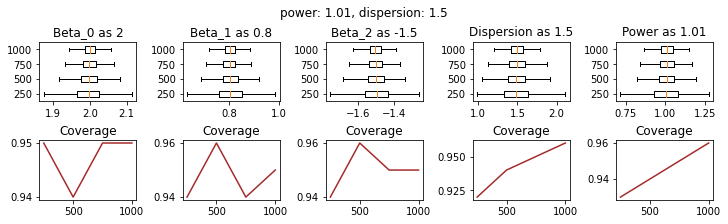

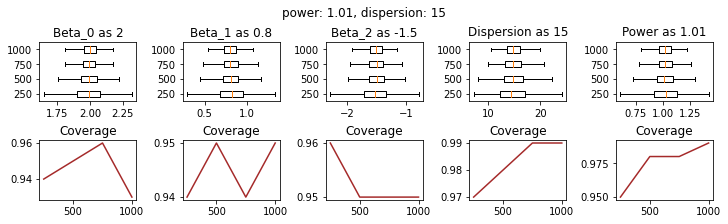

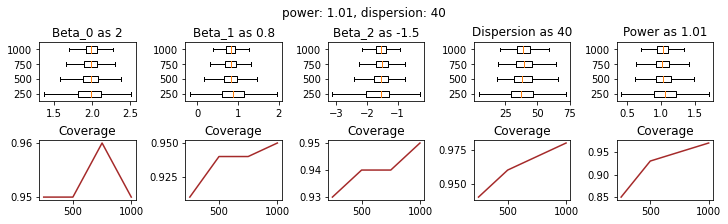

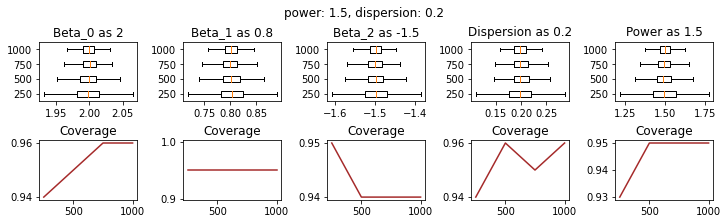

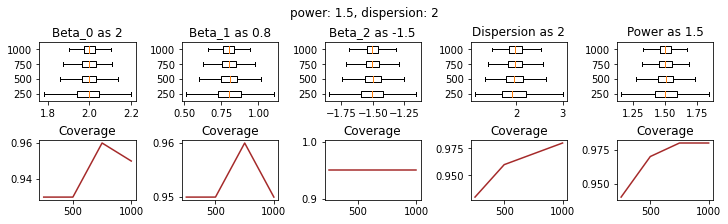

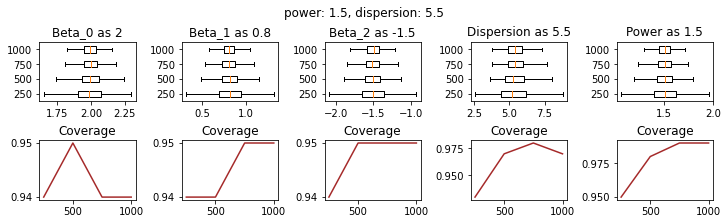

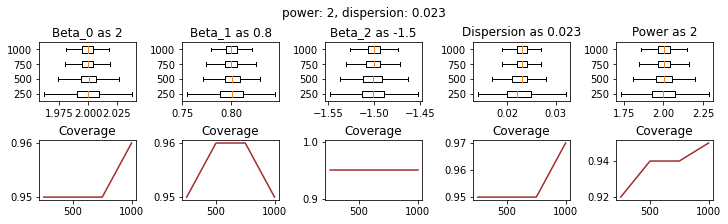

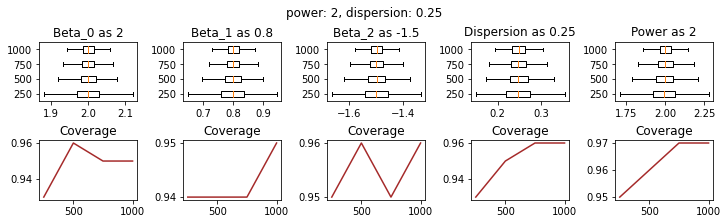

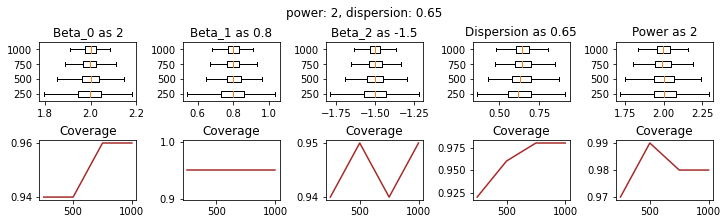

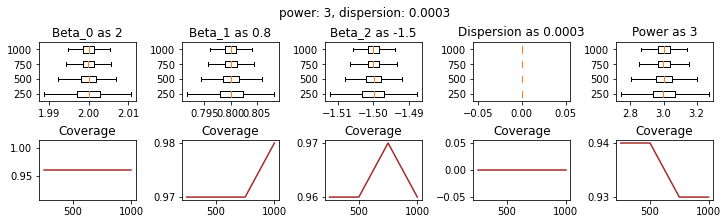

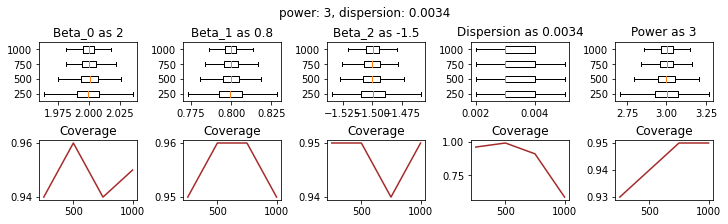

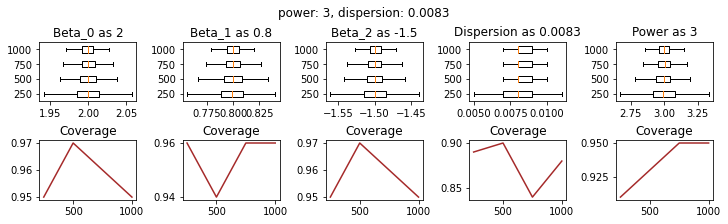

In [15]:
n_sim = 1000
sample_sizes = [250, 500, 750, 1000]
betas_tweedie = {'beta_0': 2, 'beta_1': 0.8, 'beta_2': -1.5}

for simulation_conf in [
        {"power": 1.01, "dispersion":[1.5, 15, 40], "model_type":"tweedie", "regression_parameter": betas_tweedie}, 
        {"power": 1.5, "dispersion":[0.2, 2, 5.5], "model_type": "tweedie", "regression_parameter": betas_tweedie},
        {"power": 2, "dispersion":[0.023, 0.25, 0.65], "model_type": "gamma", "regression_parameter": betas_tweedie},
        {"power": 3, "dispersion":[0.0003, 0.0034, 0.0083], "model_type": "invgauss", "regression_parameter": betas_tweedie}
        ]:
        red_square = dict(markerfacecolor='r', marker='s')

        for index_dispersion in range(len(simulation_conf["dispersion"])):
                dispersion = simulation_conf["dispersion"][index_dispersion]
                # print dispersion and power
                beta_0 = list()
                beta_1 = list()
                beta_2 = list()
                dispersion_lst = list()
                power_lst = list()
                
                beta0_coverage = list()
                beta1_coverage = list()
                beta2_coverage = list()
                dispersion_coverage = list()
                power_coverage = list()
                for sample_size in range(len(sample_sizes)):     
                        data = json.load(open('log/fixed_power/power_'+ str(simulation_conf["power"]) + \
                                '__' + 'n_sim_' + str(n_sim) +  \
                                '__' + 'dispersion_' + str(dispersion) + \
                                '__' + 'sample_size_' + str(sample_sizes[sample_size])+'__power_fixed.json', 'r'))
                        
                        beta_0.append(data["beta0"])
                        beta_1.append(data["beta1"])
                        beta_2.append(data["beta2"])
                        dispersion_lst.append(data["dispersion"])
                        power_lst.append(data["power"])
                        
                        beta0_coverage.append(round(sum(data["beta0_confidence_interval"])/n_sim, 2))
                        beta1_coverage.append(round(sum(data["beta1_confidence_interval"])/n_sim, 2))
                        beta2_coverage.append(round(sum(data["beta2_confidence_interval"])/n_sim, 2))
                        dispersion_coverage.append(round(sum(data["dispersion_confidence_interval"])/n_sim, 2))
                        power_coverage.append(round(sum(data["power_confidence_interval"])/n_sim, 2))
                        
                figure, axis = plt.subplots(2, 5, figsize=(10,3), constrained_layout=True)
                plt.suptitle('power: ' + str(simulation_conf["power"]) + ', dispersion: ' + str(dispersion))
                axis[0][0].boxplot(beta_0, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][0].set_title("Beta_0 as " + str(simulation_conf['regression_parameter']['beta_0']))
                axis[1][0].plot(sample_sizes, beta0_coverage, color="brown")
                axis[1][0].set_title("Coverage")
                #for sample_size in range(len(sample_sizes)): 
                #        axis[1][sample_size].hist(beta_1[sample_size])
                
                axis[0][1].boxplot(beta_1, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][1].set_title("Beta_1 as " + str(simulation_conf['regression_parameter']['beta_1']))
                axis[1][1].plot(sample_sizes, beta1_coverage, color="brown")
                axis[1][1].set_title("Coverage")

                #for sample_size in range(len(sample_sizes)): 
                #        axis[2][sample_size].hist(beta_2[sample_size])
                axis[0][2].boxplot(beta_2, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][2].set_title("Beta_2 as " + str(simulation_conf['regression_parameter']['beta_2']))   
                axis[1][2].plot(sample_sizes, beta2_coverage, color="brown")
                axis[1][2].set_title("Coverage")
                

                axis[0][3].boxplot(dispersion_lst, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][3].set_title("Dispersion as " + str(dispersion))
                axis[1][3].plot(sample_sizes, dispersion_coverage, color="brown")
                axis[1][3].set_title("Coverage")
                
                axis[0][4].boxplot(power_lst, vert=False, labels=sample_sizes, showfliers=False)
                axis[0][4].set_title("Power as "+str(simulation_conf["power"]))
                axis[1][4].plot(sample_sizes, power_coverage, color="brown")
                axis[1][4].set_title("Coverage")
                plt.show()

        #axis[0][0].text(-1.8, 0.4, 'Dispersion '+str(simulation_conf["dispersion"][0]), horizontalalignment='center', verticalalignment='center', transform=axis[0][0].transAxes)
                
        #axis[1][0].text(-1.8, 0.4, 'Dispersion '+str(simulation_conf["dispersion"][1]), horizontalalignment='center', verticalalignment='center', transform=axis[1][0].transAxes)
        
        #axis[2][0].text(-1.8, 0.4, 'Dispersion '+str(simulation_conf["dispersion"][2]), horizontalalignment='center', verticalalignment='center', transform=axis[2][0].transAxes)
        plt.show()
             